In [1]:
#general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob
from astropy.time import Time
import json
import copy
import scipy
import argparse
import warnings

In [2]:
# pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [3]:
import bilby
from bilby.core.prior import Uniform, DeltaFunction
from bilby.core.likelihood import GaussianLikelihood

In [4]:
# nflows
from nflows.nn.nets.resnet import ResidualNet
from nflows import transforms, distributions, flows
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedUMNNAutoregressiveTransform
from nflows.transforms.coupling import CouplingTransform, UMNNCouplingTransform
from nflows.transforms import CompositeTransform, RandomPermutation
import nflows.utils as torchutils

In [5]:
# extras
from IPython.display import clear_output
from time import sleep
import corner

In [6]:
# checking gpu status (cpu only for M1 mac)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device=}")

Using device=device(type='cuda')


# Importing the Data for Ka2017

Light curve generation is done through the nmma package on github: https://github.com/nuclear-multimessenger-astronomy/nmma/tree/main. Here, the model used is from Kasen 2017. 

In [7]:
# getting data path

fix_path = '/work/submit/mmdesai/Ka2017_data/outdir_Ka2017_fixed'
var_path = '/work/submit/mmdesai/Ka2017_data/outdir_Ka2017_varied'

In [8]:
# function to access any json file quickly

def open_json(file_name, dir_path):
    ''' Opens a json file, loads the data as a dictionary, and closes the file 
        file_name = /name of json file.json
        dir_path = directory containing json files 
    '''
    f = open(dir_path + file_name)
    data = json.load(f)
    f.close()
    return data

In [9]:
def get_fixed_names(num):
    ''' Gets the file path for the fixed data
        num = number of files to unpack
        returns: list of fixed file names
    '''
    fixed_names = []
    for i in range(0, num):
        file_name = '/fixed_{}.json'.format(i)
        fixed_names.append(file_name)
    return fixed_names

def get_varied_names(num):
    ''' Gets the file path for the varied data 
        num = number of files to unpack
        returns: list of varied file names
    '''
    varied_names = []
    for i in range(0, num):
        file_name = '/varied_{}.json'.format(i)
        varied_names.append(file_name)
    return varied_names


In [10]:
def get_band_lengths(data_df, file_names, dir_path):
    ''' Gets the length of non-22 magnitude values for all bands
        data_df = dataframe where values are stored
        file_names = list of json file names to open and analyze
        Returns: DataFrame with number of non-22 magnitudes in bands
                 as well the initial and final time of non-22 values in the i band
    '''
    bands = ['ztfg', 'ztfr', 'ztfi']
    len_df = pd.DataFrame(columns=['ztfg', 'ztfr', 'ztfi', 't_init', 't_fin', 'sim_id'], index=range(len(file_names)))

    for k, name in enumerate(file_names):
        data = open_json(name, dir_path)
        counter_list = []
        t_list = []
        for j in range(len(data)):
            band_name = bands[j]
            counter = 0
            for i in range(len(data[band_name])):
                m_val = data[band_name][i][1]
                t_val = data[band_name][i][0]
                if m_val != 22.0:
                    counter += 1
                    t_list.append(t_val)
            counter_list.append(counter)
        counter_list.append(t_list[0])
        counter_list.append(t_list[-1])
        counter_list.append(k)
        len_df.loc[k] = counter_list

    return len_df

In [11]:

def organize_ztf_data(data):
    ''' Sorts the time and magnitude data of the given JSON file according to photometric band
        data = JSON file loaded as a dictionary, example: data = open_json('/fixed_0.json', path)
    '''
    data_df = pd.DataFrame()
    bands = ['ztfg', 'ztfr', 'ztfi']

    for i in range(len(data)):
        m_data = []
        t_data = []
        for j in range(len(data[bands[i]])):
            t_val = data[bands[i]][j][0]
            m_val = data[bands[i]][j][1]
            t_data.append(t_val)
            m_data.append(m_val)
        data_df['t'] = t_data
        data_df['m_{}'.format(bands[i])] = m_data

    return data_df

In [12]:
# function to store data in a dataframe

def get_all_data(file_names, dir_path):
    ''' Congregates data from many files into one dataframe
        storage_df = dataframe where you want to store the values
        file_names = list of json file names 
    '''
    
    storage_list = []
    
    for i, name in enumerate(file_names):
        data = open_json(name, dir_path)
        onefile_df = organize_ztf_data(data)
        onefile_df['sim_id'] = np.full((len(onefile_df)), i)
        storage_list.append(onefile_df)
        
    storage_df = pd.concat(storage_list)

    return storage_df


In [13]:
# get the file names of the data

fixed_names = get_fixed_names(50000)
varied_names = get_varied_names(50000)

In [14]:
# # check the length of the band values for the fixed data

# fixed_lengths = pd.DataFrame()
# fixed_lengths = get_band_lengths(fixed_lengths, fixed_names, fix_path)
# fixed_lengths

In [15]:
# # check the length of the band values for the fixed data

# varied_lengths = pd.DataFrame()
# varied_lengths = get_band_lengths(varied_lengths, varied_names, var_path)
# varied_lengths

,ztfg,ztfr,ztfi,t_init,t_fin,sim_id
0,5,16,31,44242.535826,44250.035826,0
1,5,16,31,44246.207445,44253.707445,1
2,5,16,31,44247.154185,44254.654185,2
3,5,16,31,44247.512462,44255.012462,3
4,5,16,31,44245.049925,44252.549925,4
...,...,...,...,...,...,...
49995,27,37,38,44245.287025,44254.537025,49995
49996,27,37,38,44249.770165,44259.020165,49996
49997,27,37,38,44247.718395,44256.968395,49997
49998,27,37,38,44247.45491,44256.70491,49998


In [16]:
# # determine the time window for the light curves

# start_val = varied_lengths['t_init'].min()
# end_val = varied_lengths['t_fin'].max()
# num_points = (end_val - start_val) * 4
# print(start_val, end_val, num_points)

44242.25045696197 44290.06109369806 191.24254694435513


In [14]:
start_val = 44242.25045696197
end_val = 44290.06109369806
num_points = 191.24254694435513

In [15]:
# function to get light curve data in a certain time window

def get_windowed_data(file_names, dir_path, start_val = start_val, end_val = end_val):

    onefile_df = pd.DataFrame()
    frames = []
    bands = ['ztfg', 'ztfr', 'ztfi']

    for name in range(len(file_names)):
        data = open_json(file_names[name], dir_path)
        for band in range(len(data)):
            band_name = bands[band]
            m_data = []
            t_data = []
            counter = 0
            for j in range(len(data[band_name])):
                t_val = data[band_name][j][0]
                m_val = data[band_name][j][1]
                if t_val >= start_val and t_val <= end_val and counter < 191:
                    t_data.append(t_val)
                    m_data.append(m_val)
                    counter += 1
                else:
                    pass
            if len(t_data) != 191:
                for num in range(191 - len(t_data)):
                    t_data.append(t_data[-1] + 1)
                    m_data.append(22.0)
            else:
                pass
            onefile_df['t'] = t_data
            onefile_df['m_{}'.format(bands[band])] = m_data
        onefile_df['sim_id'] = np.full((len(onefile_df)), name)
        frames.append(onefile_df)
    
    storage_df = pd.concat(frames)
    storage_df = storage_df.reset_index(drop = True)

    return storage_df

In [16]:
# # get the fixed data
# # fixed_names_lite = get_fixed_names(1000)
# fixed_df = pd.DataFrame()
# fixed_data = get_windowed_data(fixed_df, fixed_names, fix_path)
# fixed_data

In [17]:
# # create batch list

# batch_list = []
# batch_no = 0

# for i in range(0, 1000):
#     for j in range(0, 191*50):
#         batch_list.append(batch_no)
#     batch_no += 1

In [20]:
# # adding batch column to fixed data

# fixed_data['batch_id'] = batch_list
# fixed_data

In [21]:
# # save varied and fixed data as csv files

# fixed_data.to_csv('Ka2017_fixed_data.csv', index = False)

In [22]:
# # get the varied data

# varied_df = pd.DataFrame()
# varied_data = get_windowed_data(varied_df, varied_names, var_path)
# varied_data

In [23]:
# # adding batch column to fixed data

# varied_data['batch_id'] = batch_list
# varied_data

In [24]:
# # save varied and fixed data as csv files

# varied_data.to_csv('Ka2017_varied_data.csv', index = False)

In [18]:
# read in the data

fixed_data = pd.read_csv('/work/submit/mmdesai/Ka2017_fixed_data.csv')
varied_data = pd.read_csv('/work/submit/mmdesai/Ka2017_varied_data.csv')


In [19]:
varied_data

,t,m_ztfg,m_ztfr,m_ztfi,sim_id,batch_id
0,44242.285826,22.000000,22.000000,22.000000,0,0
1,44242.535826,21.195147,20.865269,21.487027,0,0
2,44242.785826,20.137532,19.417519,19.806742,0,0
3,44243.035826,20.551534,19.075998,19.387574,0,0
4,44243.285826,21.021820,19.329091,19.358404,0,0
...,...,...,...,...,...,...
9549995,44288.815796,22.000000,22.000000,22.000000,49999,999
9549996,44289.065796,22.000000,22.000000,22.000000,49999,999
9549997,44289.315796,22.000000,22.000000,22.000000,49999,999
9549998,44289.565796,22.000000,22.000000,22.000000,49999,999


In [20]:
fixed_data

,t,m_ztfg,m_ztfr,m_ztfi,sim_id,batch_id
0,44242.500220,22.0,22.0,22.0,0,0
1,44242.750220,22.0,22.0,22.0,0,0
2,44243.000220,22.0,22.0,22.0,0,0
3,44243.250220,22.0,22.0,22.0,0,0
4,44243.500220,22.0,22.0,22.0,0,0
...,...,...,...,...,...,...
9549995,44289.000221,22.0,22.0,22.0,49999,999
9549996,44289.250221,22.0,22.0,22.0,49999,999
9549997,44289.500221,22.0,22.0,22.0,49999,999
9549998,44289.750221,22.0,22.0,22.0,49999,999


In [21]:
print(varied_data.isnull().values.any(), fixed_data.isnull().values.any())

False False


In [22]:
# fixed
fixed_inj_df = pd.DataFrame()
fixed_params = open_json('/injection_fixed.json', fix_path)
fixed_inj_df['sim_id'] = fixed_params['injections']['content']['simulation_id']
fixed_inj_df['mej'] = fixed_params['injections']['content']['log10_mej']
fixed_inj_df['vej'] = fixed_params['injections']['content']['log10_vej']
fixed_inj_df['luminosity_distance'] = fixed_params['injections']['content']['luminosity_distance']
fixed_inj_df['Xlan'] = fixed_params['injections']['content']['log10_Xlan']
fixed_inj_df['shift'] = fixed_params['injections']['content']['timeshift']

In [23]:
fixed_wparams = fixed_data.merge(fixed_inj_df, on = 'sim_id')
fixed_wparams

,t,m_ztfg,m_ztfr,m_ztfi,sim_id,batch_id,mej,vej,luminosity_distance,Xlan,shift
0,44242.500220,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
1,44242.750220,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
2,44243.000220,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
3,44243.250220,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
4,44243.500220,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9549995,44289.000221,22.0,22.0,22.0,49999,999,-1.300046,-0.660139,50.0,-4.0,0.0
9549996,44289.250221,22.0,22.0,22.0,49999,999,-1.300046,-0.660139,50.0,-4.0,0.0
9549997,44289.500221,22.0,22.0,22.0,49999,999,-1.300046,-0.660139,50.0,-4.0,0.0
9549998,44289.750221,22.0,22.0,22.0,49999,999,-1.300046,-0.660139,50.0,-4.0,0.0


In [24]:
# varied
varied_inj_df = pd.DataFrame()
varied_params = open_json('/injection_varied.json', var_path)
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['luminosity_distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['Xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']

In [25]:
# add batch id to injection dataframes

batch_list_inj = []
batch_no = 0

for i in range(0, 1000):
    for j in range(0, 50):
        batch_list_inj.append(batch_no)
    batch_no += 1

In [26]:
vinj_batch = varied_inj_df.copy()
vinj_batch['batch_id'] = batch_list_inj
vinj_batch

,sim_id,mej,vej,luminosity_distance,Xlan,shift,batch_id
0,0,-2.234525,-1.045008,50.0,-4.0,-1.964393,0
1,1,-2.234525,-1.045008,50.0,-4.0,1.707225,0
2,2,-2.234525,-1.045008,50.0,-4.0,2.653966,0
3,3,-2.234525,-1.045008,50.0,-4.0,3.012243,0
4,4,-2.234525,-1.045008,50.0,-4.0,0.549706,0
...,...,...,...,...,...,...,...
49995,49995,-1.300046,-0.660139,50.0,-4.0,0.786804,999
49996,49996,-1.300046,-0.660139,50.0,-4.0,5.269944,999
49997,49997,-1.300046,-0.660139,50.0,-4.0,3.218174,999
49998,49998,-1.300046,-0.660139,50.0,-4.0,2.954689,999


In [27]:
finj_batch = fixed_inj_df.copy()
finj_batch['batch_id'] = batch_list_inj
finj_batch

,sim_id,mej,vej,luminosity_distance,Xlan,shift,batch_id
0,0,-2.234525,-1.045008,50.0,-4.0,0.0,0
1,1,-2.234525,-1.045008,50.0,-4.0,0.0,0
2,2,-2.234525,-1.045008,50.0,-4.0,0.0,0
3,3,-2.234525,-1.045008,50.0,-4.0,0.0,0
4,4,-2.234525,-1.045008,50.0,-4.0,0.0,0
...,...,...,...,...,...,...,...
49995,49995,-1.300046,-0.660139,50.0,-4.0,0.0,999
49996,49996,-1.300046,-0.660139,50.0,-4.0,0.0,999
49997,49997,-1.300046,-0.660139,50.0,-4.0,0.0,999
49998,49998,-1.300046,-0.660139,50.0,-4.0,0.0,999


In [28]:
varied_wparams = varied_data.merge(varied_inj_df, on = 'sim_id')
varied_wparams

,t,m_ztfg,m_ztfr,m_ztfi,sim_id,batch_id,mej,vej,luminosity_distance,Xlan,shift
0,44242.285826,22.000000,22.000000,22.000000,0,0,-2.234525,-1.045008,50.0,-4.0,-1.964393
1,44242.535826,21.195147,20.865269,21.487027,0,0,-2.234525,-1.045008,50.0,-4.0,-1.964393
2,44242.785826,20.137532,19.417519,19.806742,0,0,-2.234525,-1.045008,50.0,-4.0,-1.964393
3,44243.035826,20.551534,19.075998,19.387574,0,0,-2.234525,-1.045008,50.0,-4.0,-1.964393
4,44243.285826,21.021820,19.329091,19.358404,0,0,-2.234525,-1.045008,50.0,-4.0,-1.964393
...,...,...,...,...,...,...,...,...,...,...,...
9549995,44288.815796,22.000000,22.000000,22.000000,49999,999,-1.300046,-0.660139,50.0,-4.0,3.065575
9549996,44289.065796,22.000000,22.000000,22.000000,49999,999,-1.300046,-0.660139,50.0,-4.0,3.065575
9549997,44289.315796,22.000000,22.000000,22.000000,49999,999,-1.300046,-0.660139,50.0,-4.0,3.065575
9549998,44289.565796,22.000000,22.000000,22.000000,49999,999,-1.300046,-0.660139,50.0,-4.0,3.065575


In [29]:
# visualizing the spread of the injection parameters
print(varied_wparams.max())
print(varied_wparams.min())

t                      44300.000186
m_ztfg                    22.867879
m_ztfr                    22.912338
m_ztfi                    23.066333
sim_id                 49999.000000
batch_id                 999.000000
mej                       -1.002641
vej                       -0.530699
luminosity_distance       50.000000
Xlan                      -4.000000
shift                      5.999967
dtype: float64
t                      44242.250457
m_ztfg                    17.078315
m_ztfr                    16.359215
m_ztfi                    15.960726
sim_id                     0.000000
batch_id                   0.000000
mej                       -2.999881
vej                       -1.519946
luminosity_distance       50.000000
Xlan                      -4.000000
shift                     -1.999863
dtype: float64


In [30]:
priors = dict()

priors['mej'] = Uniform(-4, 0, name='log10_mej', latex_label='$\log(Mej)$')
priors['vej'] = Uniform(-2, 0, name='log10_vej', latex_label='$\log(Vej)$')
priors['shift'] = Uniform(-3, 7, name='shift', latex_label='$\Delta\;t$')

In [31]:
# # visualizing number of non-22 magnitude data points per band for the files

# plt.hist(varied_lengths['ztfg'], color = 'g', alpha = 0.5, label = 'g', edgecolor = 'k')
# plt.hist(varied_lengths['ztfr'], color = 'r', alpha = 0.5, label = 'r', edgecolor = 'k')
# plt.hist(varied_lengths['ztfi'], color = 'c', alpha = 0.5, label = 'i', edgecolor = 'k')
# plt.xlabel('Number of non-22 magnitude values')
# plt.ylabel('Number of simulations')
# plt.legend()


[-3.   -2.75 -2.5  -2.25 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5 ]


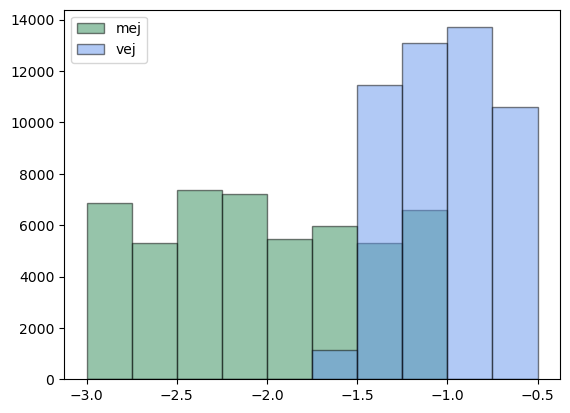

In [32]:
bins = np.linspace(-3.0, -0.5, 11)
print(bins)
plt.hist(fixed_inj_df['mej'], bins = bins, alpha = 0.5, color = 'seagreen', label = 'mej', edgecolor = 'k')
plt.hist(fixed_inj_df['vej'], bins = bins, alpha = 0.5, color = 'cornflowerblue', label = 'vej', edgecolor = 'k')
plt.legend()

In [33]:
# custom color list
ztf_bands = ['g', 'r', 'i']
base_colors = ['mediumseagreen', 'indianred', 'plum', 'm', 'b', 'y', 'k']

# plotting functions

def plot_light_curve(data_df, sim_id, bands, title = None, colors = base_colors):
    ''' Plots a light curve in the specified bands. 
        data_df = dataframe containing the time and magnitude data for all bands
        sim_num = integer that refers to the file/simulation you want to plot 
        title(Opt) = string containing plot title
        bands(Fixed) = uses default bands, takes a list of photometric band labels
        colors(Fixed) = uses default colors, takes a list of custom colors if desired '''

    onefile_data = data_df.loc[data_df['sim_id'] == sim_id]
    for i in range(len(bands)):
        plt.scatter(onefile_data['t'], onefile_data.iloc[:, i+1], label = bands[i], color = base_colors[i])
        plt.gca().invert_yaxis()
        plt.xlabel('Time')
        plt.ylabel('Magnitude')
        plt.legend()

    if title:
        plt.title(title)

    plt.show()

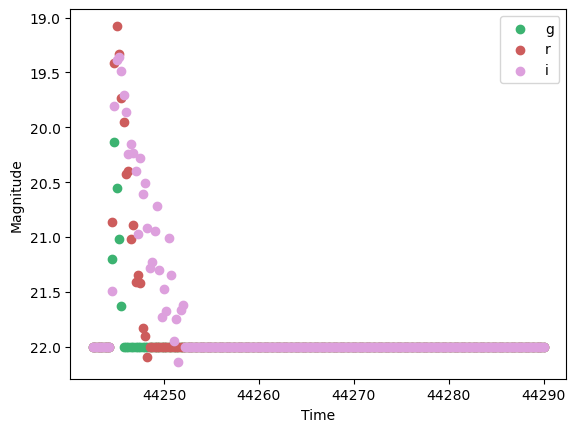

In [34]:
plot_light_curve(fixed_data, 0, ztf_bands)

In [35]:
def subplotting_lightcurve(data_df, sim_id, bands):
    onefile_data = data_df.loc[data_df['sim_id'] == sim_id]
    mej = onefile_data.iloc[]
    vej = onefile_data.iloc[]
    fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(10,7))
    for i in range(len(bands)):
        axs[i].scatter(onefile_data['t'], onefile_data.iloc[:, i+1], label = bands[i], color = base_colors[i], s = 10)
        plt.gca().invert_yaxis()
        axs[i].legend()
    fig.supxlabel('Time')
    fig.supylabel('Magnitude')


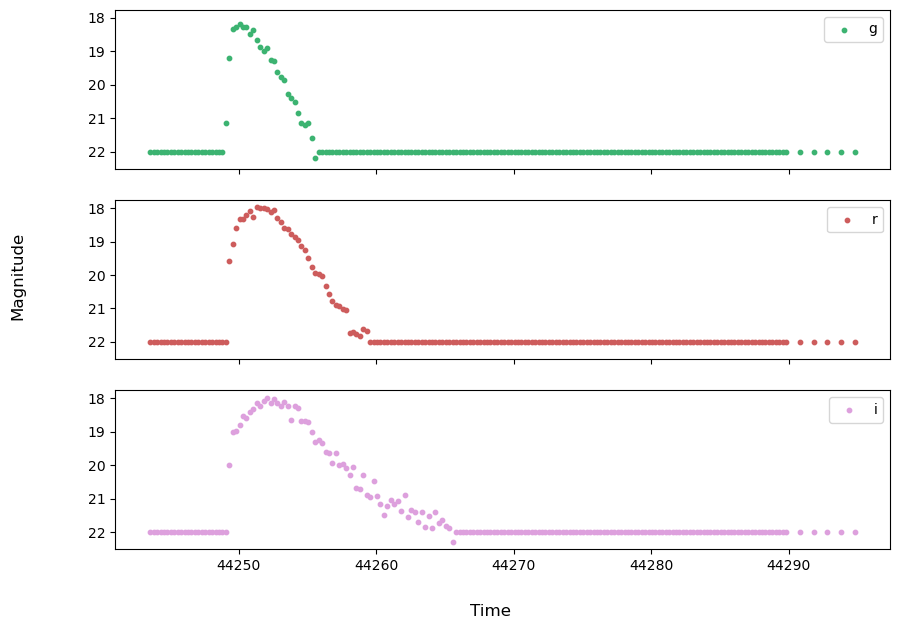

In [130]:
subplotting_lightcurve(varied_wparams, 300, ztf_bands)

In [37]:
# split data based on log10 Mej parameter, range (-3, -1)

mej1_df = fixed_wparams.loc[fixed_wparams['mej'] >= -1.5].reset_index(drop = True)
mej2_df = fixed_wparams.loc[(fixed_wparams['mej'] < -1.5) & (fixed_wparams['mej'] >= -2.0)].reset_index(drop = True)
mej3_df = fixed_wparams.loc[(fixed_wparams['mej'] < -2.0) & (fixed_wparams['mej'] >= -2.5)].reset_index(drop = True)
mej4_df = fixed_wparams.loc[(fixed_wparams['mej'] < -2.5)].reset_index(drop = True)


(array([257850., 152800., 219650., 257850., 276950., 219650., 143250.,
        315150., 181450., 248300.]),
 array([-1.51875805, -1.41995215, -1.32114626, -1.22234036, -1.12353446,
        -1.02472856, -0.92592266, -0.82711677, -0.72831087, -0.62950497,
        -0.53069907]),
 <BarContainer object of 10 artists>)

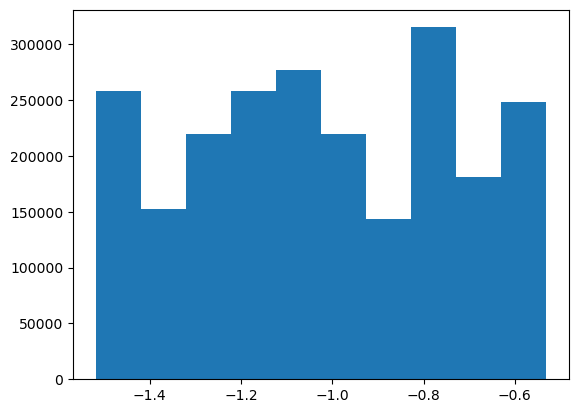

In [124]:
plt.hist(mej1_df['vej'])

In [38]:
# split data based on log10 Vej parameter, range (-1.52, -0.53)

vej1_df = fixed_wparams.loc[fixed_wparams['vej'] >= -0.78].reset_index(drop = True)
vej2_df = fixed_wparams.loc[(fixed_wparams['vej'] < -0.78) & (fixed_wparams['vej'] >= -1.03)].reset_index(drop = True)
vej3_df = fixed_wparams.loc[(fixed_wparams['vej'] < -1.03) & (fixed_wparams['vej'] >= -1.28)].reset_index(drop = True)
vej4_df = fixed_wparams.loc[(fixed_wparams['vej'] < -1.28)]

In [39]:
def plot_param(df, color):

    sim_id = pd.unique(df['sim_id'])

    for i in range(len(sim_id)):
        onefile_data = df.loc[df['sim_id'] == sim_id[i]]
        plt.scatter(onefile_data.iloc[0:25, 0], onefile_data.iloc[0:25, 3], alpha = 0.25, color = color)
    plt.gca().invert_yaxis()
    plt.xlabel('Time')
    plt.ylabel('Magnitude')

In [ ]:
# sim_list = pd.unique(varied_data['sim_id'])
# color = 'slateblue'
# color_list = ['thistle', 'slateblue', 'darkslateblue', 'mediumaquamarine']

# for i in range(len(sim_list)):
#     onefile_data = varied_data.loc[varied_data['sim_id'] == sim_list[i]]
#     plt.scatter(onefile_data.iloc[:, 0], onefile_data.iloc[:, 3], alpha = 0.25, color = color)
# plt.gca().invert_yaxis()
# plt.xlabel('Time')
# plt.ylabel('Magnitude')
# plt.title('All Data Overplotted')

In [48]:
# df_list = [mej1_df, mej2_df, mej3_df, mej4_df]
# color_list = ['thistle', 'slateblue', 'darkslateblue', 'mediumaquamarine']
# labels = ['-1.0 to -1.5', '-1.5 to -2.0', '-2.0 to -2.5', '-2.5 to -3.0']

# from matplotlib.lines import Line2D

# for j in range(len(df_list)):
#     df = df_list[j]
#     color = color_list[j]
#     sim_id = pd.unique(df['sim_id'])
#     label = labels[j]
#     for i in range(len(sim_id)):
#         onefile_data = df.loc[df['sim_id'] == sim_id[i]]
#         plt.scatter(onefile_data.iloc[:, 0], onefile_data.iloc[:, 3], alpha = 0.05, color = color)

# custom_lines = [Line2D([0], [0], color='thistle', lw=4),
#                 Line2D([0], [0], color='slateblue', lw=4),
#                 Line2D([0], [0], color='darkslateblue', lw=4),
#                 Line2D([0], [0], color='mediumaquamarine', lw=4)]

# plt.legend(custom_lines, labels)
# plt.gca().invert_yaxis()
# plt.xlabel('Time')
# plt.ylabel('Magnitude')
# plt.title('Varying Log10 Mej')


In [49]:
# df_list = [vej1_df, vej2_df, vej3_df, vej4_df]
# color_list = ['mediumpurple', 'cornflowerblue', 'skyblue', 'salmon']
# labels = ['-0.5 to -0.75', '-0.75 to -1.0', '-1.0 to -1.25', '-1.25 to -1.5', '-1.5 to -1.75']

# for j in range(len(df_list)):
#     df = df_list[j]
#     color = color_list[j]
#     sim_id = pd.unique(df['sim_id'])
#     for i in range(len(sim_id)):
#         onefile_data = df.loc[df['sim_id'] == sim_id[i]]
#         plt.scatter(onefile_data.iloc[:, 0], onefile_data.iloc[:, 3], alpha = 0.5, color = color)

# custom_lines = [Line2D([0], [0], color='plum', lw=4),
#                 Line2D([0], [0], color='cornflowerblue', lw=4),
#                 Line2D([0], [0], color='darkslateblue', lw=4),
#                 Line2D([0], [0], color='mediumaquamarine', lw=4),
#                 Line2D([0], [0], color='salmon', lw=4)]

# plt.legend(custom_lines, labels)
# plt.gca().invert_yaxis()
# plt.xlabel('Time')
# plt.ylabel('Magnitude')
# plt.title('Varying Log10 Vej')

In [40]:
# get the number of simulations

num_simulations = 1000
num_repeats = 50
num_features = 191

In [41]:
class Ka2017_data(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # get the fixed and varied data in batches of 50 for 3 bands and 98 data points

        var_mag_tensor = []
        var_mags = []
        var_curve = varied_data.loc[varied_data['batch_id'] == idx].iloc[:, 1:4]
        init_row = 0
        for i in range(num_repeats):
            one_curve = var_curve.iloc[init_row:init_row+num_features, :]
            one_curve = one_curve.transpose()
            one_curve = torch.tensor(one_curve.values, dtype = torch.float32)
            var_mags.append(one_curve)
            init_row += num_features
        var_mag_tensor.append(torch.stack(var_mags).to(device=device))

        fix_mag_tensor = []
        fix_mags = []
        fix_curve = fixed_data.loc[fixed_data['batch_id'] == idx].iloc[:, 1:4]
        init_row = 0
        for i in range(num_repeats):
            one_curve = fix_curve.iloc[init_row:init_row+num_features, :]
            one_curve = one_curve.transpose()
            one_curve = torch.tensor(one_curve.values, dtype = torch.float32)
            fix_mags.append(one_curve)
            init_row += num_features
        fix_mag_tensor.append(torch.stack(fix_mags).to(device=device))

        # get the 3 injection parameters in batches of 50 for the same x1, c    
        fix_inj = []
        fix_inj_tensor = []
        fix_inj_batch = finj_batch.loc[finj_batch['batch_id'] == idx].iloc[:, np.r_[1:3, 5]]
        for i in range(len(fix_inj_batch)):
            one_inj = fix_inj_batch.iloc[i, :]
            one_inj = torch.tensor(one_inj.values, dtype = torch.float32)
            one_inj = one_inj.unsqueeze(0)
            fix_inj.append(one_inj)
        fix_inj_tensor.append(torch.stack(fix_inj).to(device=device))

        var_inj = []
        var_inj_tensor = []
        var_inj_batch = vinj_batch.loc[vinj_batch['batch_id'] == idx].iloc[:, np.r_[1:3, 5]]
        for i in range(len(var_inj_batch)):
            one_inj = var_inj_batch.iloc[i, :]
            one_inj = torch.tensor(one_inj.values, dtype = torch.float32)
            one_inj = one_inj.unsqueeze(0)
            var_inj.append(one_inj)
        var_inj_tensor.append(torch.stack(var_inj).to(device=device))

        return (var_inj_tensor[0],    # 50 x 1 x 3  tensor
                fix_inj_tensor[0],    # 50 x 1 x 3  tensor
                var_mag_tensor[0],    # 50 x 3 x 191 tensor
                fix_mag_tensor[0]     # 50 x 3 x 191 tensor
               )



In [42]:
# define the dataset

dataset = Ka2017_data()

In [43]:
# check the dataset for a sample index

var_inj, fix_inj, var_data, fix_data = dataset[10]
print(var_inj.size(), fix_inj.size(), var_data.size(), fix_data.size())

torch.Size([50, 1, 3]) torch.Size([50, 1, 3]) torch.Size([50, 3, 191]) torch.Size([50, 3, 191])


In [44]:
# split dataset into training, testing, and validation

train_set_size = int(0.8 * num_simulations)    # 800
test_set_size = int(0.1 * num_simulations)     # 100
val_set_size = int(0.1 * num_simulations)      # 100

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_set_size, val_set_size, test_set_size])

In [45]:
# note that validation only needs 1 batch

train_data_loader = DataLoader(train_data, 50, shuffle = True)  # 80 batches
test_data_loader = DataLoader(test_data, 1, shuffle = True)     # 1  batch of 100 
val_data_loader = DataLoader(val_data, 50, shuffle = True)      # 10 batches

In [46]:
# check lengths

len(train_data_loader), len(test_data_loader), len(val_data_loader)

(16, 100, 2)

In [46]:
# check first instance of data

for var_inj, fix_inj, var_data, fix_data in train_data_loader:
    break

In [47]:
# check data size

var_inj.shape, var_data.shape, fix_inj.shape, fix_data.shape

(torch.Size([50, 50, 1, 3]),
 torch.Size([50, 50, 3, 191]),
 torch.Size([50, 50, 1, 3]),
 torch.Size([50, 50, 3, 191]))

In [48]:
# function for compressing outer two dimensions

def compress_data(data_loader):
    for var_inj, fix_inj, var_data, fix_data in data_loader:
        var_inj = var_inj.reshape((-1,)+var_inj.shape[2:])
        fix_inj = fix_inj.reshape((-1,)+fix_inj.shape[2:])
        var_data = var_data.reshape((-1,)+var_data.shape[2:])
        fix_data = fix_data.reshape((-1,)+fix_data.shape[2:])
    return var_inj, fix_inj, var_data, fix_data


In [57]:
# checking the compression

var_inj, fix_inj, var_data, fix_data = compress_data(train_data_loader)
var_inj.shape, var_data.shape

(torch.Size([2500, 1, 3]), torch.Size([2500, 3, 191]))

# Loss Function

In [47]:
# functions for similarity loss

class VICRegLoss(nn.Module):
    def __init__(self, lambda_param=1, mu_param=1,
                 nu_param=20, sort_tolerance=1.0,
                 sort_reg='l2'):

        super().__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        self.tolerance = sort_tolerance
        self.reg = sort_reg

    def forward(self, x, y, wt_repr=1.0, wt_cov=1.0, wt_std=1.0):
        repr_loss = F.mse_loss(x, y)

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)
        N = x.size(0)
        D = x.size(1)

        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        x = (x-x.mean(dim=0))/x.std(dim=0)
        y = (y-y.mean(dim=0))/y.std(dim=0)

        # transpose dims 1 and 2; keep batch dim i.e. 0, unchanged
        cov_x = (x.transpose(1, 2) @ x) / (N - 1)
        cov_y = (y.transpose(1, 2) @ y) / (N - 1)
        cov_loss = self.off_diagonal(cov_x).pow_(2).sum().div(D)
        cov_loss += self.off_diagonal(cov_y).pow_(2).sum().div(D)

        s = wt_repr*repr_loss + wt_cov*cov_loss + wt_std*std_loss
        return s, repr_loss, cov_loss, std_loss

    def off_diagonal(self,x):
        num_batch, n, m = x.shape
        assert n == m
        # All off diagonal elements from complete batch flattened
        return x.flatten(start_dim=1)[...,:-1].view(num_batch, n - 1, n + 1)[...,1:].flatten()


In [48]:
# define the loss
vicreg_loss = VICRegLoss()


# Similarity Embedding

In [49]:
# define the neural network

class ConvResidualBlock(nn.Module):
    def __init__(
        self,
        channels,
        kernel_size,
        activation=F.relu,
        dropout_probability=0.1,
        use_batch_norm=True,
        zero_initialization=True,
    ):
        super().__init__()
        self.activation = activation

        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.batch_norm_layers = nn.ModuleList(
                [nn.BatchNorm1d(channels, eps=1e-3) for _ in range(2)]
            )
        self.conv_layers = nn.ModuleList(
            [nn.Conv1d(channels, channels, kernel_size=kernel_size, padding='same') for _ in range(2)] #2 is for 2 conv layers
        )
        self.dropout = nn.Dropout(p=dropout_probability)
        if zero_initialization:
            nn.init.uniform_(self.conv_layers[-1].weight, -1e-3, 1e-3)
            nn.init.uniform_(self.conv_layers[-1].bias, -1e-3, 1e-3)

    def forward(self, inputs):
        temps = inputs
        if self.use_batch_norm:
            temps = self.batch_norm_layers[0](temps)
        temps = self.activation(temps)
        temps = self.conv_layers[0](temps)
        if self.use_batch_norm:
            temps = self.batch_norm_layers[1](temps)
        temps = self.activation(temps)
        temps = self.dropout(temps)
        temps = self.conv_layers[1](temps)

        return inputs + temps


In [50]:
class ConvResidualNet(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        hidden_channels,
        num_blocks,
        kernel_size,
        activation=F.relu,
        dropout_probability=0.1,
        use_batch_norm=True,
    ):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.initial_layer = nn.Conv1d(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding='same',
        )
        self.blocks = nn.ModuleList(
            [
                ConvResidualBlock(
                    channels=hidden_channels,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=use_batch_norm,
                    kernel_size=kernel_size,
                )
                for _ in range(num_blocks)
            ]
        )
        self.final_layer = nn.Conv1d(
            hidden_channels, out_channels, kernel_size=1, padding='same'
        )

    def forward(self, inputs):
        temps = self.initial_layer(inputs)
        for block in self.blocks:
            temps = block(temps)
        outputs = self.final_layer(temps)

        return outputs



In [51]:
# define the similarity embedding

num_channels = 3
in_features =  191
num_dim = 2

class SimilarityEmbedding(nn.Module):
    """Simple Dense embedding"""
    def __init__(self, num_hidden_layers_f=2, num_hidden_layers_h=2, activation=torch.tanh):
        super().__init__()
        self.num_hidden_layers_f = num_hidden_layers_f
        self.num_hidden_layers_h = num_hidden_layers_h

        self.layers_f = ConvResidualNet(in_channels=num_channels, out_channels=1, hidden_channels=10,
                                        num_blocks=2, kernel_size=21)
        self.contraction_layer = nn.Linear(in_features=in_features, out_features=num_dim)
        self.expander_layer = nn.Linear(num_dim,20) # 6 dimensions
        self.layers_h = nn.ModuleList([nn.Linear(20,20) for _ in range(num_hidden_layers_h)])
        self.final_layer = nn.Linear(20, 6)

        self.activation = activation

    def forward(self, x):
        x = self.layers_f(x)
        x = self.contraction_layer(x)
        representation = torch.clone(x) #copy
        x = self.activation(self.expander_layer(x))
        for layer in self.layers_h:
            x = layer(x)
            x = self.activation(x) #activation of layer(x) in layers_h
        x = self.final_layer(x)

        return x, representation


In [52]:
# puts the neural network on the gpu
similarity_embedding = SimilarityEmbedding(num_hidden_layers_f=2, num_hidden_layers_h=2).to(device)

# optimizes
optimizer = optim.Adam(similarity_embedding.parameters(), lr=1e-3)

# sets learning rate steps
scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5) #constant lr
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3) #one cycle - increase and then decrease
scheduler_3 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 15])

In [58]:
var_data.shape

torch.Size([2500, 3, 191])

In [59]:
# checking the shapes

embed, rep = similarity_embedding(var_data)
embed.shape, rep.shape

(torch.Size([2500, 1, 6]), torch.Size([2500, 1, 2]))

In [ ]:
# embed the data and calculate the loss

emb_aug, rep_aug = similarity_embedding(var_data)
emb_orig, rep_orig = similarity_embedding(var_data)
vicreg_loss(emb_aug, emb_orig)

In [53]:
# function to train neural network for one epoch

def train_one_epoch(epoch_index, tb_writer, **vicreg_kwargs):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):

        augmented_shift, unshifted_shift, augmented_data, unshifted_data = val       # 10 X 50 X 1 x 3, # 10 x 50 x 3 x 191
        augmented_shift = augmented_shift.reshape((-1,)+augmented_shift.shape[2:])   # 500 x 1 x 3
        unshifted_shift = unshifted_shift.reshape((-1,)+unshifted_shift.shape[2:])
        augmented_data = augmented_data.reshape((-1,)+augmented_data.shape[2:])      # 500 x 3 x 191
        unshifted_data = unshifted_data.reshape((-1,)+unshifted_data.shape[2:])

        embedded_values_aug, shifted_shift = similarity_embedding(augmented_data)
        embedded_values_orig, unshifted_shift = similarity_embedding(unshifted_data)

        similar_embedding_loss, _repr, _cov, _std = vicreg_loss(
            embedded_values_aug,
            embedded_values_orig,
            **vicreg_kwargs
        )

        optimizer.zero_grad()
        similar_embedding_loss.backward()
        optimizer.step()
        # Gather data and report
        running_sim_loss += similar_embedding_loss.item()
        n = 2
        if idx % n == 0:
            last_sim_loss = running_sim_loss / n
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_sim_loss))
            print(f'Last {_repr.item():.2f}; {_cov.item():.2f}; {_std.item():.2f}')
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('SimLoss/train', last_sim_loss, tb_x)
            running_sim_loss = 0.

    return last_sim_loss



In [54]:
# function to get loss for validation set for one epoch of training

def val_one_epoch(epoch_index, tb_writer, **vicreg_kwargs):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_shift, unshifted_shift, augmented_data, unshifted_data = val
        augmented_shift = augmented_shift.reshape((-1,)+augmented_shift.shape[2:])
        unshifted_shift = unshifted_shift.reshape((-1,)+unshifted_shift.shape[2:])
        augmented_data = augmented_data.reshape((-1,)+augmented_data.shape[2:])
        unshifted_data = unshifted_data.reshape((-1,)+unshifted_data.shape[2:])

        embedded_values_aug, unshifted_shift = similarity_embedding(augmented_data)
        embedded_values_orig, unshifted_shift = similarity_embedding(unshifted_data)

        similar_embedding_loss, _repr, _cov, _std = vicreg_loss(
            embedded_values_aug,
            embedded_values_orig,
            **vicreg_kwargs
        )

        running_sim_loss += similar_embedding_loss.item()
        n = 1
        if idx % n == 0:
            last_sim_loss = running_sim_loss / n
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('SimLoss/val', last_sim_loss, tb_x)
            #print(f'Last {_repr.item():.2f}; {_cov.item():.2f}; {_std.item():.2f}')
            tb_writer.flush()
            running_sim_loss = 0.
    tb_writer.flush()

    return last_sim_loss


In [55]:
# print neural network parameters that require gradients and sum parameters

sum_param=0
for name, param in similarity_embedding.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.numel())
        sum_param+=param.numel()
print(sum_param)

layers_f.initial_layer.weight
630
layers_f.initial_layer.bias
10
layers_f.blocks.0.batch_norm_layers.0.weight
10
layers_f.blocks.0.batch_norm_layers.0.bias
10
layers_f.blocks.0.batch_norm_layers.1.weight
10
layers_f.blocks.0.batch_norm_layers.1.bias
10
layers_f.blocks.0.conv_layers.0.weight
2100
layers_f.blocks.0.conv_layers.0.bias
10
layers_f.blocks.0.conv_layers.1.weight
2100
layers_f.blocks.0.conv_layers.1.bias
10
layers_f.blocks.1.batch_norm_layers.0.weight
10
layers_f.blocks.1.batch_norm_layers.0.bias
10
layers_f.blocks.1.batch_norm_layers.1.weight
10
layers_f.blocks.1.batch_norm_layers.1.bias
10
layers_f.blocks.1.conv_layers.0.weight
2100
layers_f.blocks.1.conv_layers.0.bias
10
layers_f.blocks.1.conv_layers.1.weight
2100
layers_f.blocks.1.conv_layers.1.bias
10
layers_f.final_layer.weight
10
layers_f.final_layer.bias
1
contraction_layer.weight
382
contraction_layer.bias
2
expander_layer.weight
40
expander_layer.bias
20
layers_h.0.weight
400
layers_h.0.bias
20
layers_h.1.weight
400

In [56]:
# write to tensorboard

writer = SummaryWriter()
epoch_number = 0

In [57]:
%%time
# training the neural network for many epochs

epoch_number = 0
EPOCHS = 30

sim_val_loss = []
sim_train_loss = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    if epoch < 10:
        wt_repr, wt_cov, wt_std = (50, 1, 50)
    elif epoch < 20:
        wt_repr, wt_cov, wt_std = (25, 25, 1)
    else:
        wt_repr, wt_cov, wt_std = (1, 1, 1)

    print(f"VicReg wts: {wt_repr=} {wt_cov=} {wt_std=}")
    # Gradient tracking
    similarity_embedding.train(True)
    avg_train_loss = train_one_epoch(epoch_number, writer,
                                     wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_train_loss.append(avg_train_loss)
    
    # no gradient tracking, for validation
    similarity_embedding.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer,
                                 wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_val_loss.append(avg_val_loss)
    
    print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()


EPOCH 1:
VicReg wts: wt_repr=50 wt_cov=1 wt_std=50
 Avg. train loss/batch after 2 batches = 49.5586
Last 0.00; 0.08; 0.99
 Avg. train loss/batch after 4 batches = 49.5483
Last 0.00; 0.06; 0.99
 Avg. train loss/batch after 6 batches = 49.5612
Last 0.00; 0.08; 0.99
 Avg. train loss/batch after 8 batches = 49.5438
Last 0.00; 0.05; 0.99
 Avg. train loss/batch after 10 batches = 49.5375
Last 0.00; 0.05; 0.99
 Avg. train loss/batch after 12 batches = 49.5419
Last 0.00; 0.04; 0.99
 Avg. train loss/batch after 14 batches = 49.5363
Last 0.00; 0.05; 0.99
 Avg. train loss/batch after 16 batches = 49.5407
Last 0.00; 0.04; 0.99
Train/Val Sim Loss after epoch: 49.5407/49.5563
EPOCH 2:
VicReg wts: wt_repr=50 wt_cov=1 wt_std=50
 Avg. train loss/batch after 2 batches = 49.5353
Last 0.00; 0.05; 0.99
 Avg. train loss/batch after 4 batches = 49.5279
Last 0.00; 0.04; 0.99
 Avg. train loss/batch after 6 batches = 49.5244
Last 0.00; 0.04; 0.99
 Avg. train loss/batch after 8 batches = 49.5229
Last 0.00; 0.05;

/work/submit/mmdesai/miniconda3/envs/my-torch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 Avg. train loss/batch after 2 batches = 49.4688
Last 0.00; 0.03; 0.99
 Avg. train loss/batch after 4 batches = 49.4522
Last 0.00; 0.04; 0.99
 Avg. train loss/batch after 6 batches = 49.4189
Last 0.00; 0.04; 0.99
 Avg. train loss/batch after 8 batches = 49.4137
Last 0.00; 0.04; 0.99
 Avg. train loss/batch after 10 batches = 49.3700
Last 0.00; 0.03; 0.99
 Avg. train loss/batch after 12 batches = 49.3907
Last 0.00; 0.06; 0.99
 Avg. train loss/batch after 14 batches = 49.3472
Last 0.00; 0.05; 0.99
 Avg. train loss/batch after 16 batches = 49.3659
Last 0.00; 0.05; 0.99
Train/Val Sim Loss after epoch: 49.3659/49.3025
EPOCH 7:
VicReg wts: wt_repr=50 wt_cov=1 wt_std=50
 Avg. train loss/batch after 2 batches = 49.2373
Last 0.00; 0.04; 0.98
 Avg. train loss/batch after 4 batches = 49.1543
Last 0.00; 0.04; 0.98
 Avg. train loss/batch after 6 batches = 48.9565
Last 0.00; 0.03; 0.98
 Avg. train loss/batch after 8 batches = 48.8206
Last 0.00; 0.03; 0.97
 Avg. train loss/batch after 10 batches = 48.

/work/submit/mmdesai/miniconda3/envs/my-torch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 Avg. train loss/batch after 2 batches = 0.7701
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 4 batches = 0.7092
Last 0.00; 0.02; 0.00
 Avg. train loss/batch after 6 batches = 0.7459
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 8 batches = 0.7519
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 10 batches = 0.7180
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 12 batches = 0.6579
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 14 batches = 0.6612
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 16 batches = 0.7016
Last 0.00; 0.03; 0.00
Train/Val Sim Loss after epoch: 0.7016/0.6187
EPOCH 17:
VicReg wts: wt_repr=25 wt_cov=25 wt_std=1
 Avg. train loss/batch after 2 batches = 0.6914
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 4 batches = 0.7668
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 6 batches = 0.6818
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 8 batches = 0.7239
Last 0.00; 0.03; 0.00
 Avg. train loss/batch after 10 batches = 0.7074
Last 0.00

Text(0, 0.5, 'Loss')

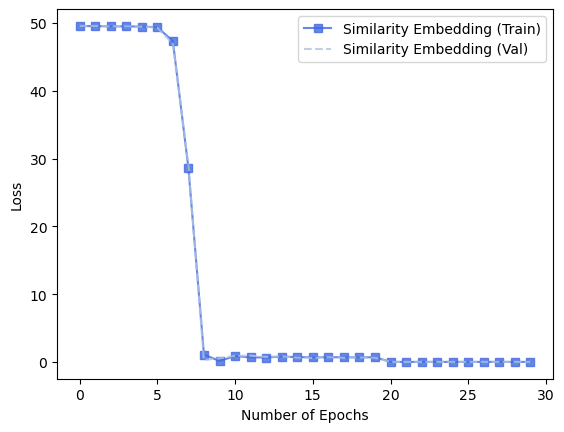

In [58]:
# plot the comparision of the train/val loss for the three scenarios

epoch_list = list(range(0,30))
plt.plot(epoch_list, sim_train_loss, label = 'Similarity Embedding (Train)', color = 'royalblue', alpha = 0.8, marker = 's')
plt.plot(epoch_list, sim_val_loss, label = 'Similarity Embedding (Val)', color = 'lightsteelblue', alpha=0.8, linestyle="dashed")
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

In [59]:
# save the embedded weights

PATH = './Ka2017-light-curves-similarity-embedding-weights.pth'
torch.save(similarity_embedding.state_dict(), PATH)

In [60]:
# load the embedded weights

PATH = './Ka2017-light-curves-similarity-embedding-weights.pth'
similarity_embedding.load_state_dict(torch.load(PATH, map_location=device))
similarity_embedding.eval()

SimilarityEmbedding(
  (layers_f): ConvResidualNet(
    (initial_layer): Conv1d(3, 10, kernel_size=(21,), stride=(1,), padding=same)
    (blocks): ModuleList(
      (0-1): 2 x ConvResidualBlock(
        (batch_norm_layers): ModuleList(
          (0-1): 2 x BatchNorm1d(10, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv_layers): ModuleList(
          (0-1): 2 x Conv1d(10, 10, kernel_size=(21,), stride=(1,), padding=same)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layer): Conv1d(10, 1, kernel_size=(1,), stride=(1,), padding=same)
  )
  (contraction_layer): Linear(in_features=191, out_features=2, bias=True)
  (expander_layer): Linear(in_features=2, out_features=20, bias=True)
  (layers_h): ModuleList(
    (0-1): 2 x Linear(in_features=20, out_features=20, bias=True)
  )
  (final_layer): Linear(in_features=20, out_features=6, bias=True)
)

# Varying $M_{ej}$

In [61]:
similarity_outputs_1 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1) and (shift_test[0][0][0] > -1.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.5) and (shift_test[0][0][0] > -2)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -2) and (shift_test[0][0][0] > -2.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -2.5) and (shift_test[0][0][0] > -3)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)



In [62]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

In [63]:
similarity_outputs_1.shape, similarity_outputs_2.shape, similarity_outputs_3.shape, similarity_outputs_4.shape

(torch.Size([27, 50, 1, 2]),
 torch.Size([25, 50, 1, 2]),
 torch.Size([22, 50, 1, 2]),
 torch.Size([26, 50, 1, 2]))

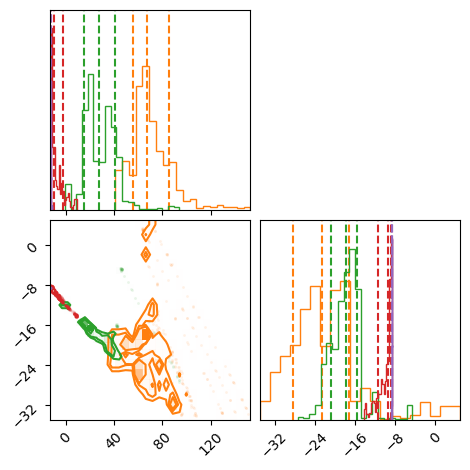

In [64]:
figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)


# Varying $V_{ej}$

In [65]:
similarity_embedding.train(False)

similarity_outputs_1 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][1] < -0.53) and (shift_test[0][0][1] > -0.78)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][1] < -0.78) and (shift_test[0][0][1] > -1.03)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][1] < -1.03) and (shift_test[0][0][1] > -1.28)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][1] < -1.28) and (shift_test[0][0][1] > -1.53)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)


In [66]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

In [67]:
similarity_outputs_1.shape, similarity_outputs_2.shape, similarity_outputs_3.shape, similarity_outputs_4.shape

(torch.Size([23, 50, 1, 2]),
 torch.Size([30, 50, 1, 2]),
 torch.Size([23, 50, 1, 2]),
 torch.Size([24, 50, 1, 2]))

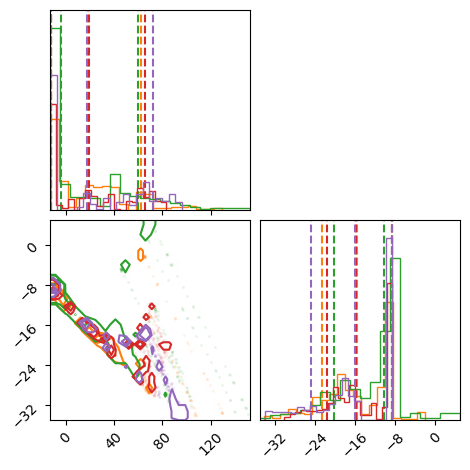

In [68]:
figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)


# Varying Both $M_{ej}$ and $V_{ej}$

In [69]:
similarity_embedding.train(False)

similarity_outputs_1 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1) and (shift_test[0][0][0] > -1.5)):
        continue
    if not ((shift_test[0][0][1] < -0.53) and (shift_test[0][0][1] > -0.78)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.5) and (shift_test[0][0][0] > -2)):
        continue
    if not ((shift_test[0][0][1] < -0.78) and (shift_test[0][0][1] > -1.03)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -2) and (shift_test[0][0][0] > -2.5)):
        continue
    if not ((shift_test[0][0][1] < -1.03) and (shift_test[0][0][1] > -1.28)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -2.5) and (shift_test[0][0][0] > -3)):
        continue
    if not ((shift_test[0][0][1] < -1.28) and (shift_test[0][0][1] > -1.53)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)



In [70]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

In [71]:
similarity_outputs_1.shape, similarity_outputs_3.shape, similarity_outputs_4.shape

(torch.Size([5, 50, 1, 2]),
 torch.Size([3, 50, 1, 2]),
 torch.Size([6, 50, 1, 2]))

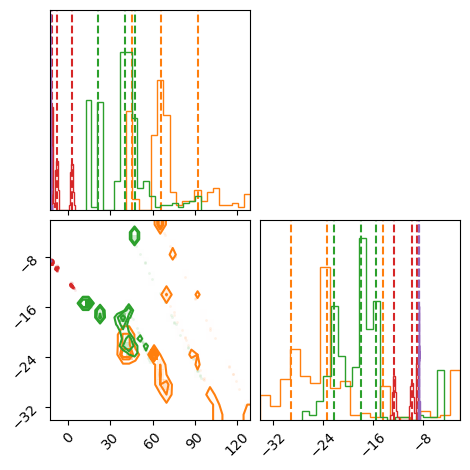

In [72]:
figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)



# Testing Embedding with Sample Light Curves

## Getting the Light Curve Data

In [73]:
set1_path = '/work/submit/mmdesai/Ka2017_data/Ka2017_batch1/'
set2_path = '/work/submit/mmdesai/Ka2017_data/Ka2017_batch2/'
set3_path = '/work/submit/mmdesai/Ka2017_data/Ka2017_batch3/'
set4_path = '/work/submit/mmdesai/Ka2017_data/Ka2017_batch4/'

In [74]:
def get_set_names(set, num):
    ''' Gets the file path for the fixed data
        num = number of files to unpack
        returns: list of fixed file names
    '''
    fixed_names = []
    for i in range(0, num):
        file_name = '/set{}_{}.json'.format(set, i)
        fixed_names.append(file_name)
    return fixed_names

In [75]:
# # get the set1 data
# set1_names = get_set_names(1, 5000)
# set1_df = pd.DataFrame()
# set1_data = get_windowed_data(set1_df, set1_names, set1_path)
# set1_data

In [76]:
# # get the set2 data
# set2_names = get_set_names(2, 5000)
# set2_df = pd.DataFrame()
# set2_data = get_windowed_data(set2_df, set2_names, set2_path)
# set2_data

In [82]:
# # get the set3 data
# set3_names = get_set_names(3, 5000)
# set3_df = pd.DataFrame()
# set3_data = get_windowed_data(set3_df, set3_names, set3_path)
# set3_data

In [83]:
# # get the set4 data
# set4_names = get_set_names(4, 5000)
# set4_df = pd.DataFrame()
# set4_data = get_windowed_data(set4_df, set4_names, set4_path)
# set4_data

In [84]:
# # adding batches

# batch_list = []
# batch_no = 0

# for i in range(0, 100):
#     for j in range(0, 191*50):
#         batch_list.append(batch_no)
#     batch_no += 1

In [85]:
# set1_data['batch_id'] = batch_list
# set2_data['batch_id'] = batch_list
# set3_data['batch_id'] = batch_list
# set4_data['batch_id'] = batch_list

In [77]:
# get the injection parameters

set1_inj_df = pd.DataFrame()
set1_params = open_json('/injection_set1.json', set1_path)
set1_inj_df['sim_id'] = set1_params['injections']['content']['simulation_id']
set1_inj_df['mej'] = set1_params['injections']['content']['log10_mej']
set1_inj_df['vej'] = set1_params['injections']['content']['log10_vej']
set1_inj_df['shift'] = set1_params['injections']['content']['timeshift']

set2_inj_df = pd.DataFrame()
set2_params = open_json('/injection_set2.json', set2_path)
set2_inj_df['sim_id'] = set2_params['injections']['content']['simulation_id']
set2_inj_df['mej'] = set2_params['injections']['content']['log10_mej']
set2_inj_df['vej'] = set2_params['injections']['content']['log10_vej']
set2_inj_df['shift'] = set2_params['injections']['content']['timeshift']

set3_inj_df = pd.DataFrame()
set3_params = open_json('/injection_set3.json', set3_path)
set3_inj_df['sim_id'] = set3_params['injections']['content']['simulation_id']
set3_inj_df['mej'] = set3_params['injections']['content']['log10_mej']
set3_inj_df['vej'] = set3_params['injections']['content']['log10_vej']
set3_inj_df['shift'] = set3_params['injections']['content']['timeshift']

set4_inj_df = pd.DataFrame()
set4_params = open_json('/injection_set4.json', set4_path)
set4_inj_df['sim_id'] = set4_params['injections']['content']['simulation_id']
set4_inj_df['mej'] = set4_params['injections']['content']['log10_mej']
set4_inj_df['vej'] = set4_params['injections']['content']['log10_vej']
set4_inj_df['shift'] = set4_params['injections']['content']['timeshift']

In [78]:
# add batch id to all the set dfs

batch_list_inj = []
batch_no = 0

for i in range(0, 100):
    for j in range(0, 50):
        batch_list_inj.append(batch_no)
    batch_no += 1

batchedinj1 = set1_inj_df.copy()
batchedinj1['batch_id'] = batch_list_inj
batchedinj2 = set2_inj_df.copy()
batchedinj2['batch_id'] = batch_list_inj
batchedinj3 = set3_inj_df.copy()
batchedinj3['batch_id'] = batch_list_inj
batchedinj4 = set4_inj_df.copy()
batchedinj4['batch_id'] = batch_list_inj

In [79]:
# # save testing data as csv files

# set1_data.to_csv('set1_data.csv', index = False)
# set2_data.to_csv('set2_data.csv', index = False)
# set3_data.to_csv('set3_data.csv', index = False)
# set4_data.to_csv('set4_data.csv', index = False)

In [80]:
# load the testing data

set1_data = pd.read_csv('/work/submit/mmdesai/set1_data.csv')
set2_data = pd.read_csv('/work/submit/mmdesai/set2_data.csv')
set3_data = pd.read_csv('/work/submit/mmdesai/set3_data.csv')
set4_data = pd.read_csv('/work/submit/mmdesai/set4_data.csv')


In [81]:
set1_data

,t,m_ztfg,m_ztfr,m_ztfi,sim_id,batch_id
0,44242.304403,22.000000,22.000000,22.000000,0,0
1,44242.554403,22.000000,22.000000,22.000000,0,0
2,44242.804403,22.000000,22.000000,22.000000,0,0
3,44243.054403,19.504648,19.101948,19.312138,0,0
4,44243.304403,18.474307,17.732727,17.758704,0,0
...,...,...,...,...,...,...
954995,44288.905952,22.000000,22.000000,22.000000,4999,99
954996,44289.155952,22.000000,22.000000,22.000000,4999,99
954997,44289.405952,22.000000,22.000000,22.000000,4999,99
954998,44289.655952,22.000000,22.000000,22.000000,4999,99


## Generating the Test Dataset

In [82]:
num_simulations = 100
num_repeats = 50
num_features = 191

In [83]:
def get_set_tensor(data_df):
    
    set_mags = []
    storage_tensor = []
    set_curve = data_df.loc[data_df['batch_id'] == idx].iloc[:, 1:4]
    init_row = 0
    for i in range(num_repeats):
        one_curve = set_curve.iloc[init_row:init_row+num_features, :]
        one_curve = one_curve.transpose()
        one_curve = torch.tensor(one_curve.values, dtype = torch.float32)
        set_mags.append(one_curve)
        init_row += num_features
    storage_tensor.append(torch.stack(set_mags).to(device=device))

    return storage_tensor

def get_setinj_tensor(data_df):

    set_inj = []
    storage_tensor = []
    set_inj_batch = data_df.loc[data_df['batch_id'] == idx].iloc[:, 1:4]
    for i in range(len(set_inj_batch)):
        one_inj = set_inj_batch.iloc[i, :]
        one_inj = torch.tensor(one_inj.values, dtype = torch.float32)
        one_inj = one_inj.unsqueeze(0)
        set_inj.append(one_inj)
    storage_tensor.append(torch.stack(set_inj).to(device=device))

    return storage_tensor

In [84]:
class set1_dataset(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # get the data in batches of 50 for 3 bands and 191 data points
        set1_mag_tensor = get_set_tensor(set1_data)
        # get the 3 injection parameters in batches of 50 for the same parameters
        set1_inj_tensor = get_setinj_tensor(batchedinj1)
        return (set1_inj_tensor[0],    # 50 x 1 x 3  tensor
                set1_mag_tensor[0],    # 50 x 3 x 191 tensor
               )
    
class set2_dataset(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # get the data in batches of 50 for 3 bands and 191 data points
        set2_mag_tensor = get_set_tensor(set2_data)
        # get the 3 injection parameters in batches of 50 for the same parameters
        set2_inj_tensor = get_setinj_tensor(batchedinj2)
        return (set2_inj_tensor[0],    # 50 x 1 x 3  tensor
                set2_mag_tensor[0],    # 50 x 3 x 191 tensor
               )
class set3_dataset(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # get the data in batches of 50 for 3 bands and 191 data points
        set3_mag_tensor = get_set_tensor(set3_data)
        # get the 3 injection parameters in batches of 50 for the same parameters
        set3_inj_tensor = get_setinj_tensor(batchedinj3)
        return (set3_inj_tensor[0],    # 50 x 1 x 3  tensor
                set3_mag_tensor[0],    # 50 x 3 x 191 tensor
               )
    
class set4_dataset(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # get the data in batches of 50 for 3 bands and 191 data points
        set4_mag_tensor = get_set_tensor(set4_data)
        # get the 3 injection parameters in batches of 50 for the same parameters
        set4_inj_tensor = get_setinj_tensor(batchedinj4)
        return (set4_inj_tensor[0],    # 50 x 1 x 3  tensor
                set4_mag_tensor[0],    # 50 x 3 x 191 tensor
               )


In [85]:
testdataset1 = set1_dataset()
testdataset2 = set2_dataset()
testdataset3 = set3_dataset()
testdataset4 = set4_dataset()

In [86]:
# check the dataset for a sample index

test1_inj, test1_data = testdataset1[10]
print(test1_inj.size(), test1_data.size())

torch.Size([50, 1, 3]) torch.Size([50, 3, 191])


In [87]:
set1_data_loader = DataLoader(testdataset1, 1, shuffle = True) 
set2_data_loader = DataLoader(testdataset2, 1, shuffle = True) 
set3_data_loader = DataLoader(testdataset3, 1, shuffle = True) 
set4_data_loader = DataLoader(testdataset4, 1, shuffle = True) 

In [88]:
for setinj_test, setdata_test in set1_data_loader:
    print(setinj_test.shape, setdata_test.shape)
    break

torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3, 191])


## Checking the Similarity Embedding with the Test Light Curves

In [125]:
similarity_outputs_1 = []

for idx, (setinj_test, setdata_test) in enumerate(set1_data_loader):
    setdata_test = setdata_test.reshape((-1,)+setdata_test.shape[2:])
    setinj_test = setinj_test.reshape((-1,)+setinj_test.shape[2:])
    with torch.no_grad():
        _, similarity_output = similarity_embedding(setdata_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (setinj_test, setdata_test) in enumerate(set2_data_loader):
    setdata_test = setdata_test.reshape((-1,)+setdata_test.shape[2:])
    setinj_test = setinj_test.reshape((-1,)+setinj_test.shape[2:])
    with torch.no_grad():
        _, similarity_output = similarity_embedding(setdata_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (setinj_test, setdata_test) in enumerate(set3_data_loader):
    setdata_test = setdata_test.reshape((-1,)+setdata_test.shape[2:])
    setinj_test = setinj_test.reshape((-1,)+setinj_test.shape[2:])
    with torch.no_grad():
        _, similarity_output = similarity_embedding(setdata_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (setinj_test, setdata_test) in enumerate(set4_data_loader):
    setdata_test = setdata_test.reshape((-1,)+setdata_test.shape[2:])
    setinj_test = setinj_test.reshape((-1,)+setinj_test.shape[2:])
    with torch.no_grad():
        _, similarity_output = similarity_embedding(setdata_test)
    similarity_outputs_4.append(similarity_output)



In [126]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

In [127]:
similarity_outputs_1.shape, similarity_outputs_2.shape, similarity_outputs_3.shape, similarity_outputs_4.shape

(torch.Size([100, 50, 1, 2]),
 torch.Size([100, 50, 1, 2]),
 torch.Size([100, 50, 1, 2]),
 torch.Size([100, 50, 1, 2]))

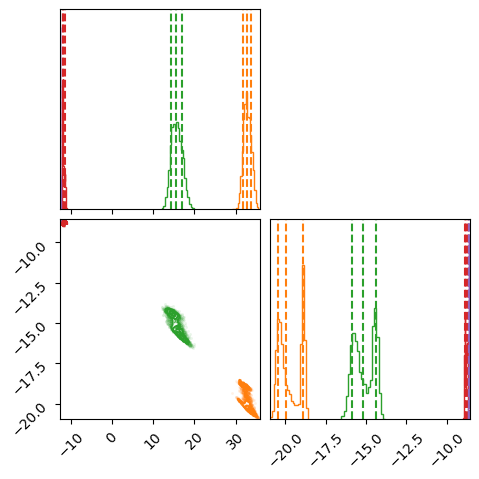

In [128]:
figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)



# Partially Freeze the Similarity Embedding

In [93]:
# make embeddeding net trainable
for name, param in similarity_embedding.named_parameters():
    param.requires_grad = True

In [103]:
# make embeddeding net untrainable
for name, param in similarity_embedding.named_parameters():
    param.requires_grad = False

In [106]:
# class EmbeddingNet(nn.Module):
#     """Wrapper around the similarity embedding defined above"""
#     def forward(self, x):
#         batch_size, channels, dims = x.shape
#         # x = x.repeat(50, 1, 1)
#         _, rep = similarity_embedding(x) # 500, 3, 191 -> 500, 1, 2
#         # rep = rep[0:batch_size] # -> 10, 1, 2
#         return rep.reshape(batch_size, 2)

In [107]:
# embeddingnet = EmbeddingNet()(torch.randn(2500, 3, 191).to(device))

In [94]:
class EmbeddingNet(nn.Module):
    """Wrapper around the similarity embedding defined above"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.representation_net = SimilarityEmbedding(num_hidden_layers_f=2, num_hidden_layers_h=2)
        # self.representation_net.load_state_dict(similarity_embedding.state_dict())

        # # the expander network is unused and hence don't track gradients
        # for name, param in self.representation_net.named_parameters():
        #     if 'expander_layer' in name or 'layers_h' in name or 'final_layer' in name:
        #         param.requires_grad = False
        # # unfreeze part of the conv layer of embedding_net
        #     elif 'layers_f' in name:
        #         param.requires_grad = True
        #     else: 
        #         param.requires_grad = True
                
        self.context_layer = nn.Sequential(
            nn.Linear(num_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_dim)
        )
    def forward(self, x):
        # batch_size, _, dims = x.shape
        # x = x.reshape(batch_size, 1, dims).repeat(1, num_repeats, 1)
        # _, rep = self.representation_net(x)
        batch_size, channels, dims = x.shape
        # x = x.repeat(50, 1, 1)
        _, rep = self.representation_net(x) # 500, 3, 191 -> 500, 1, 2
        # rep = rep[0:batch_size] # -> 10, 1, 2
        rep = rep.reshape(batch_size, 2)

        return self.context_layer(rep)

In [96]:
# check what layers are frozen

rep_net = SimilarityEmbedding(num_hidden_layers_f=2, num_hidden_layers_h=2)

# the expander network is unused and hence don't track gradients
for name, param in rep_net.named_parameters():
    if 'expander_layer' in name or 'layers_h' in name or 'final_layer' in name:
        param.requires_grad = False
        print(name, param.requires_grad)
# unfreeze part of the conv layer of embedding_net
    elif 'layers_f' in name:
        param.requires_grad = True
        print(name, param.requires_grad)
    else: 
        param.requires_grad = True
        print(name, param.requires_grad)

layers_f.initial_layer.weight True
layers_f.initial_layer.bias True
layers_f.blocks.0.batch_norm_layers.0.weight True
layers_f.blocks.0.batch_norm_layers.0.bias True
layers_f.blocks.0.batch_norm_layers.1.weight True
layers_f.blocks.0.batch_norm_layers.1.bias True
layers_f.blocks.0.conv_layers.0.weight True
layers_f.blocks.0.conv_layers.0.bias True
layers_f.blocks.0.conv_layers.1.weight True
layers_f.blocks.0.conv_layers.1.bias True
layers_f.blocks.1.batch_norm_layers.0.weight True
layers_f.blocks.1.batch_norm_layers.0.bias True
layers_f.blocks.1.batch_norm_layers.1.weight True
layers_f.blocks.1.batch_norm_layers.1.bias True
layers_f.blocks.1.conv_layers.0.weight True
layers_f.blocks.1.conv_layers.0.bias True
layers_f.blocks.1.conv_layers.1.weight True
layers_f.blocks.1.conv_layers.1.bias True
layers_f.final_layer.weight False
layers_f.final_layer.bias False
contraction_layer.weight True
contraction_layer.bias True
expander_layer.weight False
expander_layer.bias False
layers_h.0.weight 

In [109]:
# # activate for random similarity embedding

# _, rep = similarity_embedding(torch.randn(2500, 3, 191).to(device))

In [97]:
num_transforms = 8
num_blocks = 4
hidden_features = 50

_, rep = similarity_embedding(var_data)
context_features = rep.shape[-1]

base_dist = StandardNormal([2])

transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=2,  # 2-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,  # 2
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.01,
#             integrand_net_layers=[20, 20]
        ),
        RandomPermutation(features=2)
    ]
    transforms += block

transform = CompositeTransform(transforms)

embedding_net = EmbeddingNet()

flow = Flow(transform, base_dist, embedding_net).to(device=device)
# flow = Flow(transform, base_dist).to(device=device)

In [129]:
# the expander network is unused and hence don't track gradients
for name, param in flow._embedding_net.named_parameters():
    #if 'expander_layer' in name or 'layers_h' in name or 'final_layer' in name:
    #    param.requires_grad = False
    #    print(name, param.requires_grad)
# unfreeze part of the conv layer of embedding_net
    #elif 'layers_f' in name:
    #    param.requires_grad = True
    #    print(name, param.requires_grad)
    #else: 
    #    param.requires_grad = True
    print(name, param.requires_grad)

representation_net.layers_f.initial_layer.weight True
representation_net.layers_f.initial_layer.bias True
representation_net.layers_f.blocks.0.batch_norm_layers.0.weight True
representation_net.layers_f.blocks.0.batch_norm_layers.0.bias True
representation_net.layers_f.blocks.0.batch_norm_layers.1.weight True
representation_net.layers_f.blocks.0.batch_norm_layers.1.bias True
representation_net.layers_f.blocks.0.conv_layers.0.weight True
representation_net.layers_f.blocks.0.conv_layers.0.bias True
representation_net.layers_f.blocks.0.conv_layers.1.weight True
representation_net.layers_f.blocks.0.conv_layers.1.bias True
representation_net.layers_f.blocks.1.batch_norm_layers.0.weight True
representation_net.layers_f.blocks.1.batch_norm_layers.0.bias True
representation_net.layers_f.blocks.1.batch_norm_layers.1.weight True
representation_net.layers_f.blocks.1.batch_norm_layers.1.bias True
representation_net.layers_f.blocks.1.conv_layers.0.weight True
representation_net.layers_f.blocks.1.co

In [98]:
print("Total number of trainable parameters: ", sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  186578


In [99]:
for idx, val in enumerate(train_data_loader, 1):
    augmented_shift, unshifted_shift, augmented_data, unshifted_data = val
    augmented_shift = augmented_shift[...,0:2]
    break

In [100]:
augmented_data.shape, augmented_shift.shape

(torch.Size([50, 50, 3, 191]), torch.Size([50, 50, 1, 2]))

In [101]:
augmented_data.reshape(-1, 3, 191).shape

torch.Size([2500, 3, 191])

In [102]:
similarity_embedding(augmented_data[0])[1].shape

torch.Size([50, 1, 2])

In [103]:

for idx, val in enumerate(train_data_loader, 1):
    augmented_shift, unshifted_shift, augmented_data, unshifted_data = val
    augmented_shift = augmented_shift[...,0:2]
    break
        
augmented_shift.shape

torch.Size([50, 50, 1, 2])

# Train and Validate

In [104]:
num_augmentations = 50

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for idx, val in enumerate(train_data_loader, 1):
        augmented_shift, unshifted_shift, augmented_data, unshifted_data = val
        augmented_shift = augmented_shift[...,0:2] # 10, 50, 1, 2
        augmented_shift = augmented_shift.reshape(-1, 2)  # 500 x 2
        augmented_data = augmented_data.reshape(-1, 3, 191)  # 500 x 3 x 191

        loss = 0
        # for ii in range(num_augmentations):
        #     augmented_shift = augmented_shift[:,ii,:] # 10, 1, 2
        #     augmented_shift = augmented_shift.squeeze()  #10, 2
        #     augmented_data = augmented_data[:,ii,:] # 10, 1, 3, 191
        #     augmented_data = augmented_data.squeeze()   #10, 3, 191

        flow_loss = -flow.log_prob(augmented_shift, context=augmented_data).mean()
        optimizer.zero_grad()
        flow_loss.backward()
        optimizer.step()
        loss += flow_loss.item()

        running_loss += loss/num_augmentations
        n = 2
        if idx % n == 0:
            last_loss = running_loss / n # avg loss
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss



In [105]:
def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_shift, unshifted_shift, augmented_data, unshifted_data = val
        augmented_shift = augmented_shift[...,0:2]
        augmented_shift = augmented_shift.reshape(-1, 2)  # 2500 x 2
        augmented_data = augmented_data.reshape(-1, 3, 191)  # 2500 x 3 x 191
        
        loss = 0
        # for ii in range(num_augmentations):
        #     augmented_shift = augmented_shift[:,ii,:] # 10, 1, 2
        #     augmented_shift = augmented_shift.squeeze()  #10, 2
        #     augmented_data = augmented_data[:,ii,:] # 10, 1, 3, 191
        #     augmented_data = augmented_data.squeeze() #10, 3, 191

        flow_loss = -flow.log_prob(augmented_shift, context=augmented_data).mean()
        loss += flow_loss.item()

        running_loss += loss/num_augmentations
        n = 1
        if idx % n == 0:
            last_loss = running_loss / n
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [106]:
for idx, val in enumerate(val_data_loader, 1):
    augmented_shift, unshifted_shift, augmented_data, unshifted_data = val
    augmented_shift = augmented_shift[...,0:2]
    augmented_shift = augmented_shift.reshape(-1, 2)  # 500 x 2
    augmented_data = augmented_data.reshape(-1, 3, 191)  # 500 x 3 x 191
    print(augmented_shift.shape, augmented_data.shape)
    break

torch.Size([2500, 2]) torch.Size([2500, 3, 191])


In [107]:
# optimizer = optim.Adam(flow.parameters(), lr=2e-3)

# scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
# scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3)
# scheduler_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
# scheduler = optim.lr_scheduler.SequentialLR(
#     optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

optimizer = optim.SGD(flow.parameters(), lr=1e-3, momentum=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, threshold=0.001)


In [108]:
writer = SummaryWriter()

In [109]:
%%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
EPOCHS = 30
epoch_number = 0

train_loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    flow.train(True)
    # flow._embedding_net.train(False)
    # no gradient tracking for embedding layer
    for name, param in flow._embedding_net.named_parameters():
        param.requires_grad = True

    avg_train_loss = train_one_epoch(epoch_number, writer)
    train_loss_list.append(avg_train_loss)

    # no gradient tracking, for validation
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)
    val_loss_list.append(avg_val_loss)

    print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step(avg_val_loss)
    for param_group in optimizer.param_groups:
        print("Current LR = {:.3e}".format(param_group['lr']))

EPOCH 1:
 Avg. train loss/batch after 2 batches = 0.1701
 Avg. train loss/batch after 4 batches = 0.1609
 Avg. train loss/batch after 6 batches = 0.1280
 Avg. train loss/batch after 8 batches = 0.0916
 Avg. train loss/batch after 10 batches = 0.0645
 Avg. train loss/batch after 12 batches = 0.0484
 Avg. train loss/batch after 14 batches = 0.0565
 Avg. train loss/batch after 16 batches = 0.0717
Train/Val flow Loss after epoch: 0.0717/0.0532
Current LR = 1.000e-03
EPOCH 2:
 Avg. train loss/batch after 2 batches = 0.0511
 Avg. train loss/batch after 4 batches = 0.0409
 Avg. train loss/batch after 6 batches = 0.0312
 Avg. train loss/batch after 8 batches = 0.0335
 Avg. train loss/batch after 10 batches = 0.0290
 Avg. train loss/batch after 12 batches = 0.0287
 Avg. train loss/batch after 14 batches = 0.0285
 Avg. train loss/batch after 16 batches = 0.0240
Train/Val flow Loss after epoch: 0.0240/0.0237
Current LR = 1.000e-03
EPOCH 3:
 Avg. train loss/batch after 2 batches = 0.0255
 Avg. tra

In [136]:
# # save normalizing flow weights

# PATH2 = './Ka2017-light-curves-with-frozen-similarity-embedding-flow-weights.pth'
# torch.save(flow.state_dict(), PATH2)

In [137]:
# # save normalizing flow weights

# PATH3 = './Ka2017-light-curves-with-partially-frozen-similarity-embedding-flow-weights.pth'
# torch.save(flow.state_dict(), PATH3)

In [185]:
# # save normalizing flow weights

# PATH4 = './Ka2017-light-curves-with-no-similarity-embedding-flow-weights.pth'
# torch.save(flow.state_dict(), PATH4)

In [140]:
# save the experimental train/val loss for frozen network w. similarity embedding -- OUTDATED

# frozentrainloss_file = open("frozen_train_loss.txt", "w")
# frozentrainloss_file.writelines(str(train_loss_list))
# print("user data successfully saved to file")
# frozentrainloss_file.close()

# frozenvalloss_file = open("frozen_val_loss.txt", "w")
# frozenvalloss_file.writelines(str(val_loss_list))
# print("user data successfully saved to file")
# frozenvalloss_file.close()

# with open("frozen_train_loss.txt") as f:
#     test_train_loss_list = eval(f.read())

# with open("frozen_val_loss.txt") as f:
#     test_val_loss_list = eval(f.read())


In [131]:
# save the train/val loss for no similarity embedding -- CORRECT, KEEP AS NO EMBEDDING

# notrainloss_file = open("no_train_loss.txt", "w")
# notrainloss_file.writelines(str(train_loss_list))
# print("user data successfully saved to file")
# notrainloss_file.close()

# novalloss_file = open("no_val_loss.txt", "w")
# novalloss_file.writelines(str(val_loss_list))
# print("user data successfully saved to file")
# novalloss_file.close()

with open("no_train_loss.txt") as f:
    no_train_loss_list = eval(f.read())

with open("no_val_loss.txt") as f:
    no_val_loss_list = eval(f.read())


In [132]:
# save the train/val loss for partial similarity embedding -- CORRECT, KEEP AS PARTIALLY FROZEN

# partialtrainloss_file = open("partial_train_loss.txt", "w")
# partialtrainloss_file.writelines(str(train_loss_list))
# print("user data successfully saved to file")
# partialtrainloss_file.close()

# partialvalloss_file = open("partial_val_loss.txt", "w")
# partialvalloss_file.writelines(str(val_loss_list))
# print("user data successfully saved to file")
# partialvalloss_file.close()

with open("partial_train_loss.txt") as f:
    partial_train_loss_list = eval(f.read())

with open("partial_val_loss.txt") as f:
    partial_val_loss_list = eval(f.read())


In [133]:
# save the train/val loss for retraining similarity embedding -- OUTDATED, NEED NEW

# retraintrainloss_file = open("retrain_train_loss.txt", "w")
# retraintrainloss_file.writelines(str(train_loss_list))
# print("user data successfully saved to file")
# retraintrainloss_file.close()

# retrainvalloss_file = open("retrain_val_loss.txt", "w")
# retrainvalloss_file.writelines(str(val_loss_list))
# print("user data successfully saved to file")
# retrainvalloss_file.close()

# with open("retrain_train_loss.txt") as f:
#     retrain_train_loss_list = eval(f.read())

# with open("retrain_val_loss.txt") as f:
#     retrain_val_loss_list = eval(f.read())

In [111]:
# save the train/val loss for the frozen similarity embedding -- CORRECT, PRESERVE AS FROZEN

# currenttrainloss_file = open("current_train_loss.txt", "w")
# currenttrainloss_file.writelines(str(train_loss_list))
# print("user data successfully saved to file")
# currenttrainloss_file.close()

# currentvalloss_file = open("current_val_loss.txt", "w")
# currentvalloss_file.writelines(str(val_loss_list))
# print("user data successfully saved to file")
# currentvalloss_file.close()

with open("current_train_loss.txt") as f:
    frozen_train_loss_list = eval(f.read())

with open("current_val_loss.txt") as f:
    frozen_val_loss_list = eval(f.read())

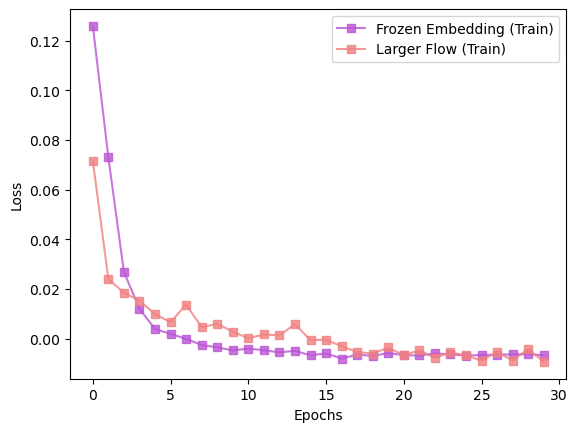

In [113]:
# plot the comparision of the train/val loss for the three scenarios

epoch_list = list(range(0,30))
plt.plot(epoch_list, frozen_train_loss_list, label = 'Frozen Embedding (Train)', color = 'mediumorchid', alpha = 0.8, marker = 's')
# # plt.plot(epoch_list, frozen_val_loss_list, label='Frozen (Val)', color='skyblue', alpha=0.8, linestyle="dashed")
# plt.plot(epoch_list, partial_train_loss_list, label = 'Flexible Embedding (Train)', color = 'seagreen', alpha=0.8, marker = 's')
# # plt.plot(epoch_list, partial_val_loss_list, label='Partial (Val)', color='orchid', alpha=0.8, linestyle="dashed")
# plt.plot(epoch_list, no_train_loss_list, label = 'No Embedding (Train)', color = 'b', alpha=0.8, marker = 's')
# # plt.plot(epoch_list, no_val_loss_list, label='None(Val)', color='salmon', alpha=0.8, linestyle="dashed")
# # plt.plot(epoch_list, retrain_train_loss_list[0:30], label = 'Unfrozen Embedding (Train)', color = 'r', alpha=0.8, marker = 's')
# # plt.plot(epoch_list, retrain_val_loss_list[0:30], label='Retrain (Val)', color='darkseagreen', alpha=0.8, linestyle="dashed")
# # plt.plot(epoch_list, test_train_loss_list, label = 'Frozen Embedding (Train)', color = 'k', alpha=0.8, marker = 's')
# # plt.plot(epoch_list, current_val_loss_list, label='current (Val)', color='plum', alpha=0.8, linestyle="dashed")

plt.plot(epoch_list, train_loss_list, label = 'Larger Flow (Train)', color = 'lightcoral', alpha=0.8, marker = 's')
# plt.plot(epoch_list, val_loss_list, label='current (Val)', color='plum', alpha=0.8, linestyle="dashed")

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [114]:
def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys({'mej', 'vej'})
    injections['mej'] = float(truth.numpy()[0])
    injections['vej'] = float(truth.numpy()[1])

    posterior = dict.fromkeys({'mej', 'vej'})
    samples_numpy = samples.numpy()
    posterior['mej'] = samples_numpy.T[0].flatten()
    posterior['vej'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

In [115]:
def live_plot_samples(samples, truth):
    print(truth)
    clear_output(wait=True)
    sleep(0.5)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        labels=["Mass of Ejecta", "Vel. of Ejecta"],
        truth=truth,
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")

In [116]:
for idx, (_, shift_test, data_test, data_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_orig = data_orig.reshape((-1,)+data_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    break

In [117]:
data_test[0].reshape((1, 3,191)).shape

torch.Size([1, 3, 191])

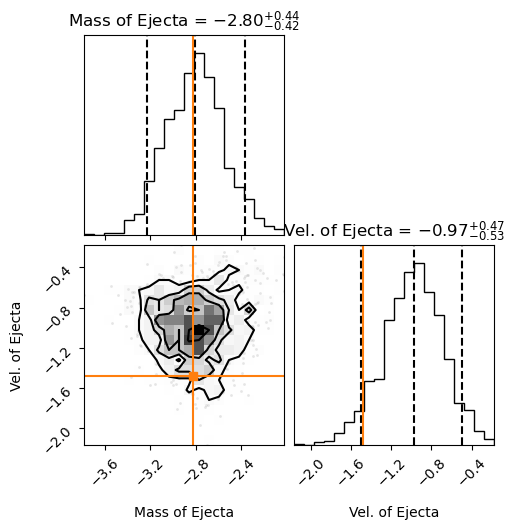

In [119]:
for idx, (_, shift_test, data_test, data_orig) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_orig = data_orig.reshape((-1,)+data_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if idx % 10 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(1000, context=data_test[0].reshape((1, 3,191)))
    live_plot_samples(samples.cpu().reshape(1000,2), shift_test[0][0].cpu()[...,0:2])
    plt.show()

# PP Plots

16:57 bilby INFO    : Key: KS-test p-value
16:57 bilby INFO    : mej: 1.1908689757059002e-11
16:57 bilby INFO    : vej: 0.1374749336479978
16:57 bilby INFO    : Combined p-value: 4.606613230672046e-11


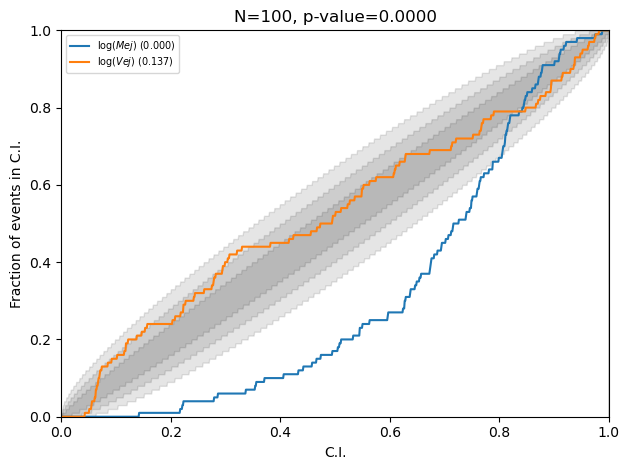

In [120]:
results = []
for idx, (_, shift_test, data_test, data_unshifted) in enumerate(test_data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_orig = data_orig.reshape((-1,)+data_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    with torch.no_grad():
        samples = flow.sample(1000, context=data_test[0].reshape((1, 3, 191)))
    results.append(
        cast_as_bilby_result(samples.cpu().reshape(1000,2), shift_test[0][0].cpu()[...,0:2]))

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['mej', 'vej'])

# MCMC Inference

In [92]:
# # define log likelihood function

# def log_prior():
#     lprior = 0
#     for i in range(len(priors)):
#         # sum log priors from each parameter
#         if i == 0:
#             # prior for uniform parameters
#             if priors[i][0] < theta[i] < priors[i][1]:
#                 pass
#             else:
#                 lprior = -np.inf
#         else:
#             # prior for non-uniform parameters
#             lprior -= 0.5*((theta[i] - priors[i][0]) / priors[i][1])**2
#     return lprior

# def log_likelihood(theta, x, y, yerr):
#     m, b, log_f = theta
#     model = m * x + b
#     sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
#     return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


# def log_posterior(p):
#         log_prior = 0.
#         for prior, p_i in zip(priors, p):
#             log_prior += prior(p_i)
#         if np.isinf(log_prior):
#             return log_prior
#         log_likelihood = model.log_likelihood(lc, p, use_sigma=use_sigma, sigma_type=sigma_type)
#         return log_prior + log_likelihood

#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

In [94]:
# start off with one light curve:
lightcurve = fixed_wparams.loc[fixed_wparams['sim_id'] == 0]
lightcurve

,t,m_ztfg,m_ztfr,m_ztfi,sim_id,batch_id,mej,vej,luminosity_distance,Xlan,shift
0,44242.50022,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
1,44242.75022,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
2,44243.00022,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
3,44243.25022,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
4,44243.50022,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
186,44289.00022,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
187,44289.25022,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
188,44289.50022,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0
189,44289.75022,22.0,22.0,22.0,0,0,-2.234525,-1.045008,50.0,-4.0,0.0


In [95]:
# print the priors

priors

{'mej': Uniform(minimum=-4, maximum=0, name='log10_mej', latex_label='$\\log(Mej)$', unit=None, boundary=None),
 'vej': Uniform(minimum=-2, maximum=0, name='log10_vej', latex_label='$\\log(Vej)$', unit=None, boundary=None),
 'shift': Uniform(minimum=-3, maximum=7, name='shift', latex_label='$\\Delta\\;t$', unit=None, boundary=None)}

In [99]:
# get the true parameters

true_mej = lightcurve.iloc[0, 6]
true_vej = lightcurve.iloc[0, 7]
print(true_mej, true_vej)

-2.2345248019730524 -1.0450075176271376


In [ ]:
def model(theta):

    mej, vej = theta
    
    alpha = 1.3
    heatingrate = 10**10 * (t**alpha)

    model = #your code here
    
    return model

In [ ]:
def log_prior():
    lprior = 0
    for i in range(len(priors)):
        # sum log priors from each parameter
        if i == 0:
            # prior for uniform parameters
            if priors[i][0] < theta[i] < priors[i][1]:
                pass
            else:
                lprior = -np.inf
        else:
            # prior for non-uniform parameters
            lprior -= 0.5*((theta[i] - priors[i][0]) / priors[i][1])**2
    return lprior

In [ ]:
# get the model

#!/usr/bin/env python3

from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
import scipy.interpolate as interp
import sncosmo
import argparse
import h5py
from astropy.cosmology import Planck18 as cosmo


def parse():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--filters",
        type=str,
        default="bessellux,bessellb,bessellv,bessellr,besselli,sdssu,ps1::g,ps1::r,ps1::i,ps1::z,ps1::y,uvot::b,uvot::u,uvot::uvm2,uvot::uvw1,uvot::uvw2,uvot::v,uvot::white,atlasc,atlaso,2massj,2massh,2massks,ztfg,ztfr,ztfi",
        help="comma-separated list of filters for photometric lcs; must be from the bandpasses listed here: \
                        https://sncosmo.readthedocs.io/en/stable/bandpass-list.html",
    )
    parser.add_argument(
        "--modeldir",
        type=str,
        help="directory where .hdf5 files are located",
        default="model/",
    )
    parser.add_argument(
        "--lcdir",
        type=str,
        help="output directory for generated lightcurves",
        default="lcs/",
    )
    parser.add_argument(
        "--doLbol",
        help="extract bolometric lightcurves",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--doAB",
        help="extract photometric lightcurves",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        '--doSmoothing',
        help='Employ Savitzky-Golay filter for smoothing',
        action="store_true",
        default=False
    )
    parser.add_argument(
        "--dMpc",
        type=float,
        help="distance in Mpc, default is 10 pc to get lightcurves in Absolute Mag",
        default=1e-5,
    )
    parser.add_argument(
        "--z",
        type=float,
        help="redshift, if provided it dominates over dMpc",
        default=None,
    )

    return parser.parse_args()


args = parse()

filters = args.filters.split(",")
lcdir = args.lcdir
if not os.path.isdir(lcdir):
    os.makedirs(lcdir)
if not args.doAB and not args.doLbol:
    raise SystemExit(
        "ERROR: Neither --doAB nor --doLbol are enabled. Please enable at least one."
    )

files = [f for f in os.listdir(args.modeldir) if "h5" in f]
numfiles = len(files)

# Use redshift or dMpc if z is not provided
if args.z is None:
    dMpc = args.dMpc
    D_cm = dMpc * 1e6 * 3.0857e18
    H0 = cosmo.H0.value
    CLIGHT = 2.99792458e5
    CLIGHT_cm_s = 1e5 * CLIGHT
    ztest = np.arange(0.0001, 1, 0.00001)
    Dtest = np.array(cosmo.luminosity_distance(ztest).to("Mpc").value)
    z = ztest[np.argmin(abs(dMpc - Dtest))]
else:
    z = args.z
    dMpc = cosmo.luminosity_distance(z).to("Mpc").value

for kk, filename in enumerate(files):
    if kk % 10 == 0:
        print(f"{kk * 100 / numfiles:.2f}% done")

    with h5py.File(os.path.join(args.modeldir, filename), "r") as f:
        nu = np.array(f["nu"], dtype="d")
        time = np.array(f["time"])
        Lnu = np.array(f["Lnu"], dtype="d")

    # smooth over missing data
    Lnu[Lnu == 0.0] = 1e20
    Lnu = 10 ** gaussian_filter(np.log10(Lnu), 3.0)

    nuS = np.tile(nu, (len(time), 1))

    Llam = Lnu * nuS**2.0 / CLIGHT_cm_s / 1e8  # ergs/s/Angstrom
    Llam = Llam / (4 * np.pi * D_cm**2)  # ergs / s / cm^2 / Angstrom

    ph = np.array(time) / (60 * 60 * 24)  # get time in days
    wave = CLIGHT_cm_s / nu * 1e8  # AA

    # flip axes to make wavelength increasing
    wave = np.flip(wave)
    Llam = np.flip(Llam, axis=1)

    # extract photometric lightcurves
    if args.doAB:
        if args.z is not None:
            lc = open(
                os.path.join(lcdir, f"{filename[:-5]}_z{z}.dat"),
                "w",
            )
        else:
            lc = open(
                os.path.join(
                    lcdir,
                    f"{filename[:-5]}_dMpc{int(dMpc)}.dat",
                ),
                "w",
            )

        lc.write(f'# t[days] {" ".join(filters)} \n')
        m_tot = []
        for filt in filters:
            source = sncosmo.TimeSeriesSource(ph, wave, Llam)
            m = source.bandmag(filt, "ab", ph)

            #apply smoothing filter
            if args.doSmoothing:
                ii = np.where(~np.isnan(m))[0]
                if len(ii) > 1:
                    f = interp.interp1d(ph[ii], m[ii], fill_value='extrapolate')
                    m = f(ph)
                m = savgol_filter(m,window_length=17,polyorder=3)

            m_tot.append(m)

        for i, t in enumerate(ph):
            if t < 0:
                continue
            lc.write(f"{t:.3f} ")
            for ifilt in range(len(filters)):
                lc.write(f"{m_tot[ifilt][i]:.3f} ")
            lc.write("\n")
        lc.close()

    # extract bolometric lightcurves
    if args.doLbol:
        if args.z is not None:
            Lbol_f = open(
                os.path.join(lcdir, f"{filename[:-5]}_z{z}_Lbol.dat"),
                "w",
            )
        else:
            Lbol_f = open(
                os.path.join(
                    lcdir,
                    f"{filename[:-5]}_dMpc{int(dMpc)}_Lbol.dat",
                ),
                "w",
            )
        Lbol_f.write("# t[days] Lbol[erg/s] \n")

        Lbol = np.trapz(
            Lnu * np.flipud(nu) ** 2.0 / CLIGHT_cm_s / 1e8 * (4 * np.pi * D_cm**2),
            x=wave,
        )

        if args.doSmoothing:
            ii = np.where(np.isfinite(np.log10(Lbol)))[0]
            f = interp.interp1d(ph[ii], np.log10(Lbol[ii]), fill_value='extrapolate')
            Lbol = 10**f(ph)
            Lbol = savgol_filter(Lbol,window_length=17,polyorder=3)

        for i, t in enumerate(ph):
            if t < 0:
                continue
            Lbol_f.write(f"{t:.3f} {Lbol[i]:.5e} \n")

        Lbol_f.close()

In [ ]:
# maximum likelihood

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)